# Load Noah's Model and replicate predictions and results
Richard Kuzma and Noah Jones <br>October 2021<br><br>

Part 1: Load model and infer on test data<br>
Part 2: Conduct error analysis<br><br>

If starting from scratch, start with Part 1. If coming back to this notebook after predictions have been saved, import libraries then start at Part 2.<br>







<br><br><br>
# Part 0 -- Imports and Load Data
<br><br><br>

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import torch
import json
import transformers
from multimodal_toolkit.multimodal_transformers.data import load_data
from multimodal_toolkit.multimodal_transformers.model import AutoModelWithTabular
from transformers import AutoConfig, AutoTokenizer, Trainer
from sklearn.metrics import classification_report, confusion_matrix
import math
import matplotlib.pyplot as plt

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
path_to_multimodal_toolkit = "multimodal_toolkit/"
config_name = "rp_config(meta).json"
data_path = path_to_multimodal_toolkit + "datasets/rp/"
path_to_checkpoint = path_to_multimodal_toolkit + "logs/roberta_pretrained_meta_text_num(final)/pred_seed_2/"

train_dataset_name = "train.csv"
val_dataset_name = "val.csv"
test_dataset_name = "test.csv"

# Load Train Data

In [4]:
train = pd.read_csv(data_path + train_dataset_name)
print(f"{len(train)} posts in Train  |  {len(train) - len(train.drop_duplicates(subset='id'))} duplicates  |  {len(train.drop_duplicates(subset='id'))} unique")
train_unique = train.drop_duplicates(subset='id')

6478 posts in Train  |  1830 duplicates  |  4648 unique


# Load val data

In [5]:
val = pd.read_csv(data_path + val_dataset_name)
print(f"{len(val)} posts in Val  |  {len(val) - len(val.drop_duplicates(subset='id'))} duplicates  |  {len(val.drop_duplicates(subset='id'))} unique")
val = val.drop_duplicates(subset='id')


692 posts in Val  |  172 duplicates  |  520 unique


# Load test data

In [6]:
test = pd.read_csv(data_path + test_dataset_name)
test.label = test.label.astype('int8')
print(f"{len(test)} posts in Test  |  {len(test) - len(test.drop_duplicates(subset='id'))} duplicates  |  {len(test.drop_duplicates(subset='id'))} unique")
test_with_dups = test.copy()
test = test.drop_duplicates(subset='id')


1712 posts in Test  |  433 duplicates  |  1279 unique


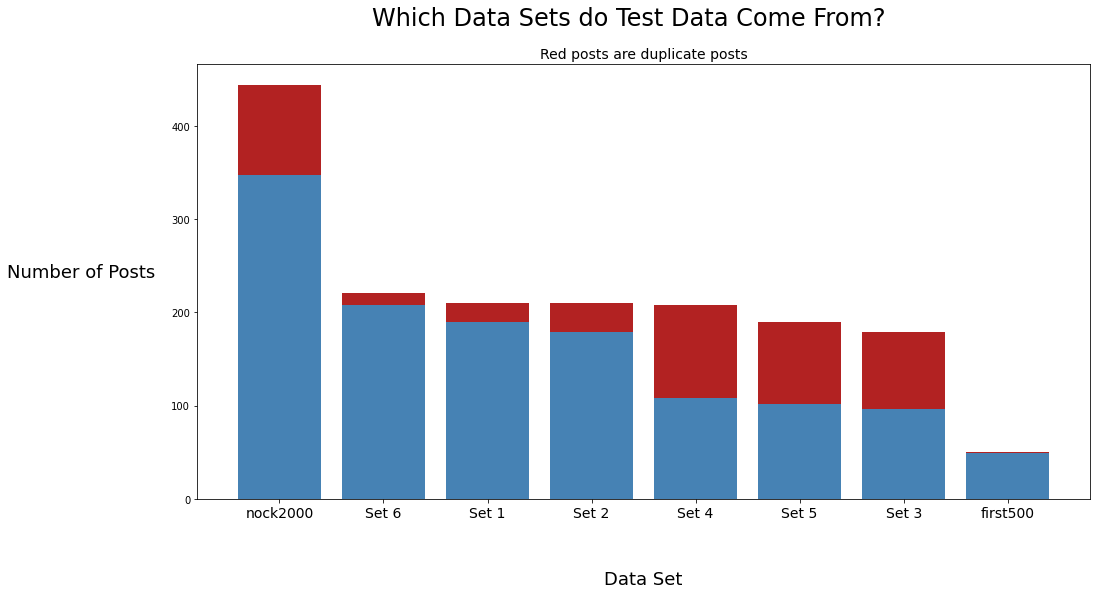

In [7]:
test_dataset_names = test.dataset.value_counts().index
test_dup_dataset_names = test_with_dups.dataset.value_counts().index
assert(set(test_dataset_names) == set(test_dup_dataset_names))
test_dataset_vals = test.dataset.value_counts().values
test_dup_dataset_vals = test_with_dups.dataset.value_counts().values

plt.figure(figsize=(16,8))
plt.bar(x=test_dataset_names, height=test_dup_dataset_vals, color="firebrick")
plt.bar(x=test_dataset_names, height=test_dataset_vals, color="steelblue")
plt.suptitle("Which Data Sets do Test Data Come From?", fontsize=24)
plt.title("Red posts are duplicate posts", fontsize=14)
plt.xlabel("Data Set", labelpad=50, fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Number of Posts", rotation=0, labelpad=90, fontsize=18)
plt.show()

<br><br><br>
# Part 1 -- Load Model and Infer
<br><br><br>

## Step 1. Tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained(path_to_checkpoint)

## Step 2. Load Data

In [9]:
with open(data_path + config_name, "r") as f:
    data_config = dict(json.load(f))

torch_dataset = load_data(
                            data_df = test_with_dups,
                            text_cols = data_config['text_cols'],
                            tokenizer=tokenizer,
                            categorical_cols= data_config['cat_cols'],
                            categorical_encode_type=None,
#                             numerical_transformer = "yeo_johnson",
                            numerical_cols= data_config['num_cols'], 
                            sep_text_token_str=tokenizer.sep_token,
                            label_col=data_config['label_col'],
                            label_list= data_config['label_list']
)

## Step 3. Load Config

In [10]:
config = AutoConfig.from_pretrained(path_to_checkpoint)

## Step 4. Load Model

In [11]:
model = AutoModelWithTabular.from_pretrained(path_to_checkpoint, config=config)

## Step 5. Make Trainer

In [12]:
trainer = Trainer(model=model)

## Step 6. Predict

In [13]:
predictions = trainer.predict(test_dataset=torch_dataset).predictions
prediction_labels = np.array([np.argmax(elem) for elem in predictions]).reshape(-1,1)

## Step 7. Save Predictions

In [14]:
with open("richard_results/" + "predictions.pkl", "wb") as f:
    pickle.dump(predictions, f)
with open("richard_results/" + "prediction_labels.pkl", "wb") as f:
    pickle.dump(prediction_labels, f)

<br><br><br>
# Part 2 -- Analyze Results
<br><br><br>

## Step 8. Load Predictions

In [15]:
with open("richard_results/" + "predictions.pkl", "rb") as f:
    predictions = pickle.load(f)
with open("richard_results/" + "prediction_labels.pkl", "rb") as f:
    prediction_labels = pickle.load(f)

In [16]:
# show a few examples of the prediction labels and raw prediction outputs
shortened_range = math.floor(len(predictions)*.01)
for idx in range(shortened_range):
    print(f"{prediction_labels[idx]} | {predictions[idx]}")

[0] | [ 3.6036606 -4.314269 ]
[0] | [ 2.38798   -3.0696485]
[1] | [-5.2031074  5.1110997]
[0] | [ 3.3068507 -4.2265496]
[0] | [ 3.897688 -4.634917]
[0] | [ 3.5907888 -4.2626977]
[0] | [ 3.8818011 -4.693766 ]
[0] | [ 3.8413038 -4.456391 ]
[0] | [ 1.1555367 -1.8302858]
[0] | [ 3.97143  -4.919062]
[0] | [ 3.5506544 -4.242747 ]
[0] | [ 3.8200712 -4.643654 ]
[0] | [ 2.7747588 -3.7051156]
[0] | [ 3.8890636 -4.4537916]
[0] | [ 3.0245528 -3.5627873]
[0] | [ 3.8220267 -4.7132716]
[0] | [ 3.025146 -3.924805]


## Step 9. Add Prediction Labels and Raw Predictions to Test DataFrame

In [17]:
test_with_dups["pred"] = prediction_labels
test_with_dups["pred_raw"] = list(predictions)
test_with_dups["id"] = test_with_dups["id"].astype("int32")

test = test_with_dups.drop_duplicates(subset='id')

print(test_with_dups.shape)
print(test.shape)


(1712, 13)
(1279, 13)


## Step 10. Generate TP, TN, FP, FN, Errors DataFrames

In [18]:
def generate_tp_tn_fp_fn_errors_dataframes(test):
    tp = test[(test["label"] == 1) & (test["pred"]==1)]
    tn = test[(test["label"] == 0) & (test["pred"]==0)]
    fp = test[(test["label"] == 0) & (test["pred"]==1)]
    fn = test[(test["label"] == 1) & (test["pred"]==0)]

    tp["prediction_error_name"] = "True Positive"
    tn["prediction_error_name"] = "True Negative"
    fp["prediction_error_name"] = "False Positive"
    fn["prediction_error_name"] = "False Negative"

    col_order = ['id', 'label', 'pred', 'pred_raw', 'prediction_error_name', 'hash', 'content', 'dataset', 'reputation', 'contact_size', 'type', 'ancestry', 'tags', 'type_tag_content']
    tp = tp[col_order]
    tn = tn[col_order]
    fp = fp[col_order]
    fn = fn[col_order]

    corrects = pd.concat([tp, tn])
    errors = pd.concat([fp, fn])
    errors["id"] = errors["id"].astype("int32")
    
    tot = len(test)
    num_tp = len(tp)
    num_tn = len(tn)
    num_fp = len(fp)
    num_fn = len(fn)
    num_errors = len(errors)
    
    print(f"Num items in test set: {len(test)}")
    print(f"Num TP: {num_tp}")
    print(f"Num TN: {num_tn}")
    print(f"Num FP: {num_fp}")
    print(f"Num FN: {num_fn}")
    print(f"\nNum Errors: {num_errors}")
    
    print("\n\nConfusion Matrix:")
    print(confusion_matrix(test["label"], test["pred"]))
    print("\n")
    print(classification_report(test["label"], test["pred"]))

    return tp, tn, fp, fn, errors, corrects

## Step 11. Show number of Errors, Confusion Matrix

In [19]:
print(f"Test Set With Duplicates: Correct Predictions, Errors, and Evaluation:\n")
tp_dup, tn_dup, fp_dup, fn_dup, errors_dup, corrects_dup = generate_tp_tn_fp_fn_errors_dataframes(test_with_dups)

Test Set With Duplicates: Correct Predictions, Errors, and Evaluation:

Num items in test set: 1712
Num TP: 113
Num TN: 1511
Num FP: 68
Num FN: 20

Num Errors: 88


Confusion Matrix:
[[1511   68]
 [  20  113]]


              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1579
           1       0.62      0.85      0.72       133

    accuracy                           0.95      1712
   macro avg       0.81      0.90      0.85      1712
weighted avg       0.96      0.95      0.95      1712



In [20]:
print(f"Test Set **Without** Duplicates: Correct Predictions, Errors, and Evaluation:\n")
tp, tn, fp, fn, errors, corrects = generate_tp_tn_fp_fn_errors_dataframes(test)

Test Set **Without** Duplicates: Correct Predictions, Errors, and Evaluation:

Num items in test set: 1279
Num TP: 94
Num TN: 1117
Num FP: 52
Num FN: 16

Num Errors: 68


Confusion Matrix:
[[1117   52]
 [  16   94]]


              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1169
           1       0.64      0.85      0.73       110

    accuracy                           0.95      1279
   macro avg       0.81      0.91      0.85      1279
weighted avg       0.96      0.95      0.95      1279



## Step 12. Examine Noah's Errors

In [21]:
noah_errors_csv = os.path.join("..", "Dataset notebook", 
                                       "Error-prone-Datasets", 
                                       "False positives and False Negatives on Test.csv")
noah_errors = pd.read_csv(noah_errors_csv)
noah_errors["id"] = noah_errors["id"].astype("int32")

print(f"{len(noah_errors)} posts in Noah's Precreated Errors set  |  {noah_errors.id.nunique()} unique posts  |   {len(noah_errors) - noah_errors.id.nunique()} duplicate posts")

print(f"\n\nNumber of each Type of Error in Noah's precreated set (with duplicates)")
print(noah_errors.prediction_error_name.value_counts())

print(f"\n\nNumber of each Type of Error in Noah's precreated set (without duplicates)")
print(noah_errors.drop_duplicates(subset='id', keep='first').prediction_error_name.value_counts())

print(f"\n\nNo user hash in Noah's data, cannot compute number of unique users in data set")

print("\n\nExamples of Duplicate Posts")
noah_errors_dups = noah_errors.copy(deep=True)
noah_errors.drop_duplicates(subset='id', keep='first', inplace=True)

noah_errors_dups[noah_errors_dups.id.duplicated(keep=False)].sort_values(by='id').head(4)



62 posts in Noah's Precreated Errors set  |  45 unique posts  |   17 duplicate posts


Number of each Type of Error in Noah's precreated set (with duplicates)
False Negative    41
False Positive    21
Name: prediction_error_name, dtype: int64


Number of each Type of Error in Noah's precreated set (without duplicates)
False Negative    30
False Positive    15
Name: prediction_error_name, dtype: int64


No user hash in Noah's data, cannot compute number of unique users in data set


Examples of Duplicate Posts


,id,type_tag_content,risk,reputation,contact_size,dataset,label,prediction_error_name
58,561476,type| comment tag| ptsd health ptsd survivors ...,3.614488,0.000111,0.000300,Set 3,1.0,False Negative
57,561476,type| comment tag| ptsd health ptsd survivors ...,3.614488,0.000111,0.000300,nock2000,1.0,False Negative
61,756400,type| comment tag| suicide body| I noticed nob...,3.973253,0.081236,0.024348,Set 3,1.0,False Negative
60,756400,type| comment tag| suicide body| I noticed nob...,3.973253,0.081236,0.024348,nock2000,1.0,False Negative


## Step 13. Compare Noah's Error set to Richard's Error set

In [22]:
outer_join =  errors.merge(noah_errors[["id", "prediction_error_name"]], on='id', how='outer', suffixes=("_richard", "_noah"), indicator=True)
col_order = ['id', 'label', 'pred', 'prediction_error_name_richard', 'prediction_error_name_noah', '_merge']
outer_join = outer_join[col_order]


print(outer_join._merge.value_counts())

print(f"\n\nNoah's error set has {len(noah_errors)} errors")
print(f"Richard's error set has {len(errors)} errors")
print(f"Combined, there are {len(outer_join)} errors")

print(f"\n\n31 errors found in both error sets")
print(f"37 errors found only in Richard's error set")
print(f"14 errors found only in Noah's error set")


left_only     37
both          31
right_only    14
Name: _merge, dtype: int64


Noah's error set has 45 errors
Richard's error set has 68 errors
Combined, there are 82 errors


31 errors found in both error sets
37 errors found only in Richard's error set
14 errors found only in Noah's error set
